In [20]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import joblib
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)


In [21]:
def extract_features(file_path, max_pad_len=174):
    """
    Enhanced feature extraction with more robust feature generation
    and padding/truncation
    """
    try:
        # Load audio file
        y, sr = librosa.load(file_path, duration=3, offset=0.5)
        
        # Extract multiple features
        stft = np.abs(librosa.stft(y))
        
        # MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        
        # Spectral features
        spectral_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        
        # Chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        
        # Tonnetz
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
        
        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y)
        
        # Pad or truncate features to a consistent length
        def pad_trunc_feature(feature, max_len):
            if feature.shape[1] > max_len:
                return feature[:, :max_len]
            pad_width = max_len - feature.shape[1]
            return np.pad(feature, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
        # Pad all features
        mfccs = pad_trunc_feature(mfccs, max_pad_len)
        spectral_cent = pad_trunc_feature(spectral_cent, max_pad_len)
        spectral_bandwidth = pad_trunc_feature(spectral_bandwidth, max_pad_len)
        spectral_rolloff = pad_trunc_feature(spectral_rolloff, max_pad_len)
        chroma = pad_trunc_feature(chroma, max_pad_len)
        tonnetz = pad_trunc_feature(tonnetz, max_pad_len)
        zcr = pad_trunc_feature(zcr, max_pad_len)
        
        # Flatten features
        features = np.concatenate([
            mfccs.ravel(),
            spectral_cent.ravel(),
            spectral_bandwidth.ravel(),
            spectral_rolloff.ravel(),
            chroma.ravel(),
            tonnetz.ravel(),
            zcr.ravel()
        ])
        
        return features
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# def get_audio_files(data_path):
#     """Get list of audio files and their corresponding emotions."""
#     audio_files = []
#     emotions = []
#     valid_extensions = ('.m4a', '.ogg', '.wav')
#     emotion_map = {
#         '01': 'neutral',
#         '02': 'calm',
#         '03': 'happy',
#         '04': 'sad',
#         '05': 'angry',
#         '06': 'fearful',
#         '07': 'disgust',
#         '08': 'surprised'
#     }
    
#     for filename in os.listdir(data_path):
#         if filename.endswith('.wav'):
#             parts = filename.split('-')
#             emotion_code = parts[2]
            
#             audio_files.append(os.path.join(data_path, filename))
#             emotions.append(emotion_map[emotion_code])
    
#     return audio_files, emotions

def get_audio_files(data_paths):
    audio_files = []
    emotions = []
    
    # Emotion mapping based on filename codes
    emotion_map = {
        '01': 'neutral',
        '02': 'calm',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fearful',
        '07': 'disgust',
        '08': 'surprised'
    }
    
    valid_extensions = ('.m4a', '.ogg', '.wav')  # Tuple of allowed file extensions

    # Loop through each directory in data_paths
    for data_path in data_paths:
        for root, _, files in os.walk(data_path):
            for filename in files:
                # Check if the file has a valid audio extension
                if filename.endswith(valid_extensions):
                    parts = filename.split('-')
                    # Assuming the third part is the emotion code
                    emotion_code = parts[2]
                    
                    # Map the emotion code to its label, if it exists in emotion_map
                    if emotion_code in emotion_map:
                        audio_files.append(os.path.join(root, filename))
                        emotions.append(emotion_map[emotion_code])
    
    return audio_files, emotions



In [22]:
def train_emotion_model(data_path):
    audio_files, emotions = get_audio_files(data_path)
    
    
    features_list = []
    print("Extracting features from audio files...")
    for file_path in tqdm(audio_files):
        features = extract_features(file_path)
        if features is not None:
            features_list.append(features)
    

    X = np.array(features_list)
    y = np.array(emotions[:len(X)])  # Ensure y matches X length
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    # Create a pipeline with scaling and classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    ])
    
    # Hyperparameter grid
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    }
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=5, 
        scoring='balanced_accuracy', 
        n_jobs=-1, 
        verbose=2
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    
    # Predictions and evaluation
    y_pred = best_model.predict(X_test)
    
    print("\nBest Parameters:", grid_search.best_params_)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    # Save model and label encoder
    joblib.dump(best_model, 'emotion_recognition_model.pkl')
    joblib.dump(label_encoder, 'label_encoder.pkl')
    
    return best_model, label_encoder

In [23]:
def predict_emotion(file_path, 
                    model_path='emotion_recognition_model.pkl', 
                    encoder_path='label_encoder.pkl'):
    """Predict emotion for a given audio file."""
    try:
        # Load the saved model and label encoder
        model = joblib.load(model_path)
        label_encoder = joblib.load(encoder_path)
        
        # Extract features
        features = extract_features(file_path)
        
        if features is None:
            print("Feature extraction failed.")
            return None
        
        # Reshape features for prediction
        features = features.reshape(1, -1)
        
        # Predict
        prediction_encoded = model.predict(features)
        prediction = label_encoder.inverse_transform(prediction_encoded)
        
        return prediction[0]

    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"An error occurred during prediction: {e}")
        return None


Extracting features from audio files...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1440/1440 [01:12<00:00, 19.81it/s]

Fitting 5 folds for each of 27 candidates, totalling 135 fits



Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

       angry       0.54      0.50      0.52        38
        calm       0.51      0.74      0.60        38
     disgust       0.55      0.55      0.55        38
     fearful       0.52      0.44      0.47        39
       happy       0.37      0.18      0.24        39
     neutral       0.45      0.53      0.49        19
         sad       0.31      0.21      0.25        38
   surprised       0.40      0.62      0.48        39

    accuracy                           0.47       288
   macro avg       0.46      0.47      0.45       288
weighted avg       0.46      0.47      0.45       288



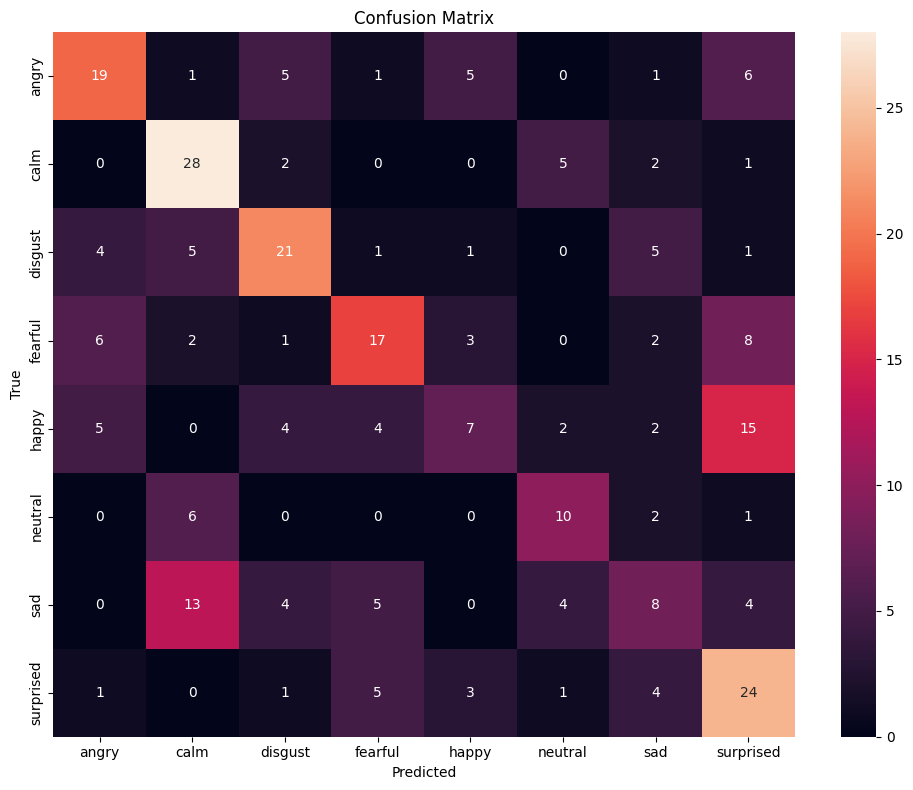

[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   5.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=50; total time=   2.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=50; total time=   2.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   4.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   8.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   5.4s
[CV] END classifier__max_depth=10, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   2.8s
[CV] END classifier__max_depth=10, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   4.2s
[CV] END classifier__max_depth=10, classifier__min_sam

In [26]:
# def main():
#     # Training
#     DATA_PATH = '../data3'
#     train_emotion_model(DATA_PATH)
    
#     # Testing
#     # test_audio_paths = [
#     #     '../test_data/test1.m4a',
#     #       '../test_data/test2.m4a',
#     #       '../test_data/test3.m4a',
#     # ]

#     # for audio_path in test_audio_paths:
#     #     try:
#     #         predicted_emotion = predict_emotion(audio_path)
#     #         if predicted_emotion:
#     #             print(f"Audio file: {audio_path}")
#     #             print(f"Predicted Emotion: {predicted_emotion}")
#     #             print("---")
#     #     except Exception as e:
#     #         print(f"Error processing {audio_path}: {e}")

# if __name__ == "__main__":
#     main()

def main():
    # Specify multiple directories
    DATA_PATHS = [ '../data2']
    best_model, label_encoder = train_emotion_model(DATA_PATHS)

    # Optional Testing Code
    # test_audio_paths = [
    #     '../test_data/test1.m4a',
    #     '../test_data/test2.m4a',
    #     '../test_data/test3.m4a',
    # ]

    # for audio_path in test_audio_paths:
    #     try:
    #         predicted_emotion = predict_emotion(audio_path, best_model, label_encoder)
    #         if predicted_emotion:
    #             print(f"Audio file: {audio_path}")
    #             print(f"Predicted Emotion: {predicted_emotion}")
    #             print("---")
    #     except Exception as e:
    #         print(f"Error processing {audio_path}: {e}")

if __name__ == "__main__":
    main()


In [ ]:
import numpy as np
import librosa
import joblib
import os
import pandas as pd
from tabulate import tabulate

def extract_features(file_path, max_pad_len=174):
    """
    Enhanced feature extraction with more robust feature generation
    and padding/truncation
    """
    try:
        # Load audio file
        y, sr = librosa.load(file_path, duration=3, offset=0.5)
        
        # Extract multiple features
        stft = np.abs(librosa.stft(y))
        
        # MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        
        # Spectral features
        spectral_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        
        # Chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        
        # Tonnetz
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
        
        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y)
        
        # Pad or truncate features to a consistent length
        def pad_trunc_feature(feature, max_len):
            if feature.shape[1] > max_len:
                return feature[:, :max_len]
            pad_width = max_len - feature.shape[1]
            return np.pad(feature, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
        # Pad all features
        mfccs = pad_trunc_feature(mfccs, max_pad_len)
        spectral_cent = pad_trunc_feature(spectral_cent, max_pad_len)
        spectral_bandwidth = pad_trunc_feature(spectral_bandwidth, max_pad_len)
        spectral_rolloff = pad_trunc_feature(spectral_rolloff, max_pad_len)
        chroma = pad_trunc_feature(chroma, max_pad_len)
        tonnetz = pad_trunc_feature(tonnetz, max_pad_len)
        zcr = pad_trunc_feature(zcr, max_pad_len)
        
        # Flatten features
        features = np.concatenate([
            mfccs.ravel(),
            spectral_cent.ravel(),
            spectral_bandwidth.ravel(),
            spectral_rolloff.ravel(),
            chroma.ravel(),
            tonnetz.ravel(),
            zcr.ravel()
        ])
        
        return features
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def predict_emotion(file_path, 
                    model_path='emotion_recognition_model.pkl', 
                    encoder_path='label_encoder.pkl'):
    """Predict emotion for a given audio file."""
    try:
        # Load the saved model and label encoder
        model = joblib.load(model_path)
        label_encoder = joblib.load(encoder_path)
        
        # Extract features
        features = extract_features(file_path)
        
        if features is None:
            print("Feature extraction failed.")
            return None
        
        # Reshape features for prediction
        features = features.reshape(1, -1)
        
        # Predict
        prediction_encoded = model.predict(features)
        prediction = label_encoder.inverse_transform(prediction_encoded)
        
        return prediction[0]

    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"An error occurred during prediction: {e}")
        return None

def batch_predict(directory):
    """Predict emotions for multiple audio files in a directory."""
    results = {}
    error_files = []
    
    # Get all .wav files in the directory
    wav_files = [f for f in os.listdir(directory) if f.endswith('.ogg')]
    
    print(f"Total WAV files found: {len(wav_files)}")
    
    for filename in wav_files:
        file_path = os.path.join(directory, filename)
        try:
            prediction = predict_emotion(file_path)
            if prediction:
                results[filename] = prediction
                print(f"Processed: {filename} - Emotion: {prediction}")
            else:
                error_files.append(filename)
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            error_files.append(filename)
    
    # Create a DataFrame for better visualization
    df_results = pd.DataFrame.from_dict(results, orient='index', columns=['Predicted Emotion'])
    df_results.index.name = 'Filename'
    
    # Emotion Distribution
    emotion_counts = df_results['Predicted Emotion'].value_counts()
    
    # Print summary
    print("\n--- Batch Prediction Summary ---")
    print("\nEmotion Distribution:")
    print(tabulate(emotion_counts.reset_index(), 
                   headers=['Emotion', 'Count'], 
                   tablefmt='pretty'))
    
    print("\nDetailed Predictions:")
    print(tabulate(df_results.reset_index(), 
                   headers=['Filename', 'Predicted Emotion'], 
                   tablefmt='pretty'))
    
    if error_files:
        print("\nFiles with Prediction Errors:")
        for error_file in error_files:
            print(error_file)
    
    return results, df_results

def main():
    # Single file prediction
    # test_audio_path = '../data/03-01-08-02-02-02-04.wav'
    # predicted_emotion = predict_emotion(test_audio_path)
    # print(f"Predicted Emotion for {test_audio_path}: {predicted_emotion}")
    
    # Batch prediction
    test_directory = '../test_data'
    batch_results, df_results = batch_predict(test_directory)

if __name__ == "__main__":
    main()